In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import Binarizer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
from sklearn.metrics import precision_recall_curve,roc_curve,confusion_matrix 


In [20]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.5,0.52,0.54,0.56,0.58,0.6,0.62]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()

In [21]:
## 불균형 처리 안한 데이터 
train = pd.read_csv("./datasets/통계검증완료/코스닥_standard_train.csv",index_col=0)
test =  pd.read_csv("./datasets/통계검증완료/코스닥_standard_test.csv",index_col=0)

id_col = ['회사명', '거래소코드', '회계년도', '산업군','target_3']


최종_col_3 = ['abs(영업현금흐름-당기순이익)/매출액', '누적수익성비율', 'WW지수','금융비용부담률', 'TMD', '순운전자본비율']

X_train = train[최종_col_3]
y_train = train["target_3"]

X_test = test[최종_col_3]
y_test = test["target_3"]

# LSTM model

In [22]:
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))


# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
141/141 [==============================] - 9s 12ms/step - loss: 0.1920 - accuracy: 0.9652
Epoch 2/100
141/141 [==============================] - 2s 11ms/step - loss: 0.0932 - accuracy: 0.9749
Epoch 3/100
141/141 [==============================] - 2s 12ms/step - loss: 0.0884 - accuracy: 0.9756
Epoch 4/100
141/141 [==============================] - 2s 12ms/step - loss: 0.0848 - accuracy: 0.9756
Epoch 5/100
141/141 [==============================] - 2s 12ms/step - loss: 0.0855 - accuracy: 0.9772
Epoch 6/100
141/141 [==============================] - 2s 11ms/step - loss: 0.0864 - accuracy: 0.9769
Epoch 7/100
141/141 [==============================] - 2s 12ms/step - loss: 0.0836 - accuracy: 0.9761
Epoch 8/100
141/141 [==============================] - 2s 11ms/step - loss: 0.0840 - accuracy: 0.9772
Epoch 9/100
141/141 [==============================] - 2s 11ms/step - loss: 0.0841 - accuracy: 0.9767
Epoch 10/100
141/141 [==============================] - 2s 11ms/step - loss: 0.081

In [32]:
pred_proba = model.predict(X_test)
binarizer = Binarizer(threshold=0.25).fit(pred_proba) 
pred = binarizer.transform(pred_proba)
eval(pred=pred,test=y_test)

80/80 [==============================] - 0s 4ms/step
##############
 [[2458   19]
 [  21   51]] ############
 acc_score: 0.9843075715967046
 f1_score: 0.7183098591549296 
 precision: 0.7285714285714285 
 recall: 0.7083333333333334


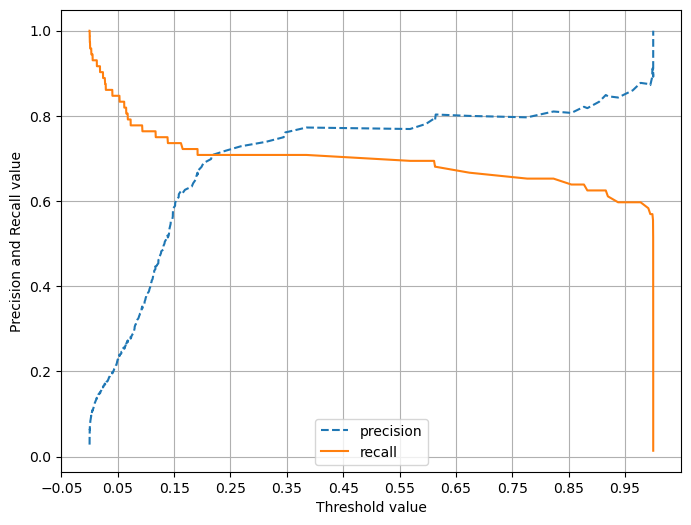

In [33]:
precision_recall_curve_plot(y_test,pred_proba)

## 다층 퍼셉트론

In [43]:
# MLP 모델 생성

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(6,)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])


# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100


c:\Users\msi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


141/141 [==============================] - 1s 2ms/step - loss: 0.3716 - accuracy: 0.9102
Epoch 2/100
141/141 [==============================] - 0s 2ms/step - loss: 0.1585 - accuracy: 0.9654
Epoch 3/100
141/141 [==============================] - 0s 2ms/step - loss: 0.1151 - accuracy: 0.9707
Epoch 4/100
141/141 [==============================] - 0s 2ms/step - loss: 0.1007 - accuracy: 0.9701
Epoch 5/100
141/141 [==============================] - 0s 3ms/step - loss: 0.0971 - accuracy: 0.9687
Epoch 6/100
141/141 [==============================] - 0s 2ms/step - loss: 0.0999 - accuracy: 0.9738
Epoch 7/100
141/141 [==============================] - 0s 2ms/step - loss: 0.0869 - accuracy: 0.9729
Epoch 8/100
141/141 [==============================] - 0s 2ms/step - loss: 0.0905 - accuracy: 0.9756
Epoch 9/100
141/141 [==============================] - 0s 2ms/step - loss: 0.0874 - accuracy: 0.9729
Epoch 10/100
141/141 [==============================] - 0s 2ms/step - loss: 0.0844 - accuracy: 0.9743
E

In [44]:
pred_proba = model.predict(X_test)
binarizer = Binarizer(threshold=0.25).fit(pred_proba) 
pred = binarizer.transform(pred_proba)
eval(pred=pred,test=y_test)

80/80 [==============================] - 0s 1ms/step
##############
 [[2455   22]
 [  19   53]] ############
 acc_score: 0.9839152608866222
 f1_score: 0.7210884353741497 
 precision: 0.7066666666666667 
 recall: 0.7361111111111112


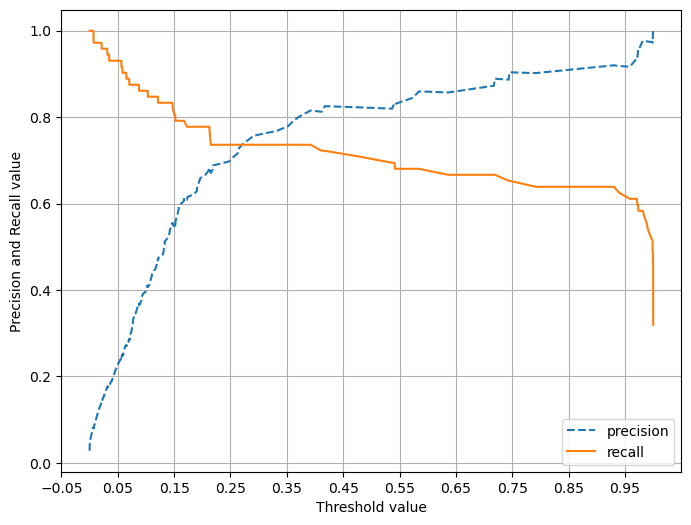

In [45]:
precision_recall_curve_plot(y_test,pred_proba)